In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2grey
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
data_dir = '../Dataset/'

In [3]:
negatives = 0
total_imgs = 0
for f in os.listdir(data_dir):
    total_imgs_list = os.listdir(data_dir+'/'+f)
    total_imgs += len(total_imgs_list)
    if (f.endswith("Healthy") and not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        negatives += len(imgs_list)
print('Number of healthy cases = ', negatives)
positives = total_imgs-negatives
print('Number of diseased cases = ', positives)

Number of healthy cases =  3218
Number of diseased cases =  15846


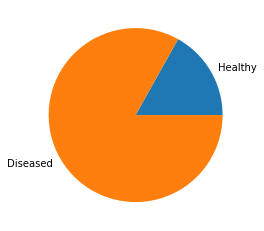

In [4]:
labels = 'Healthy','Diseased'
sizes = [negatives, positives]
plt.pie(sizes,labels=labels)
plt.show()

In [5]:
classes = {}
for f in os.listdir(data_dir):
    num = 0
    if (not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        num += len(imgs_list)
        classes[f] = num

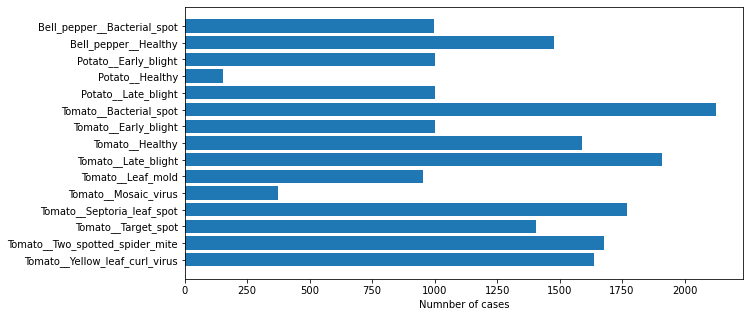

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
y_pos = np.arange(len(classes.keys()))
ax.barh(y_pos, classes.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(classes.keys())
ax.invert_yaxis()
ax.set_xlabel('Numnber of cases')

plt.show()

In [7]:
capstone_dir = os.getcwd()+'/'

data_list = []
for label in os.listdir(data_dir):
    if (not label.startswith(".")):
        imgs_list = os.listdir(data_dir + '/' + label)
        imgs_list = [i for i in imgs_list if not i.startswith(".")]
        label_list = [label]*len(imgs_list)
        if label.find('Healthy')>=0:
            binary_list = ['0']*len(imgs_list)
        else:
            binary_list = ['1']*len(imgs_list)
        data_list.extend(zip(imgs_list, label_list, binary_list))
df = pd.DataFrame(data_list, columns=['Name','Label', 'Binary'])

In [8]:
df.shape

(19064, 3)

In [9]:
df.head(3)

,Name,Label,Binary
0,0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Sp...,Bell_pepper__Bacterial_spot,1
1,006adb74-934f-448f-a14f-62181742127b___JR_B.Sp...,Bell_pepper__Bacterial_spot,1
2,00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Sp...,Bell_pepper__Bacterial_spot,1


In [10]:
df0 = df[df['Binary']=='0'].sample(n=3000, random_state=99)
df1 = df[df['Binary']=='1'].sample(n=3000, random_state=42)
df_svm = pd.concat([df0,df1])

In [11]:
df_svm.shape

(6000, 3)

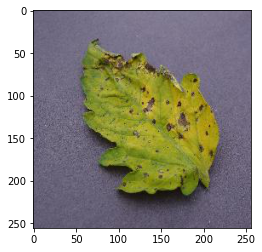

In [14]:
def get_image(img_inf, data_dir = data_dir):
    img_folder_name = img_inf['Label']
    img_file_name = img_inf['Name']
    img = Image.open(data_dir + img_folder_name + '/' + img_file_name)
    return np.array(img)

img_row = random.choice(range(6000))
img = get_image(df_svm.iloc[img_row])
plt.imshow(img)

<ipython-input-15-f8128310ef18>:1: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  grey_img = rgb2grey(img)


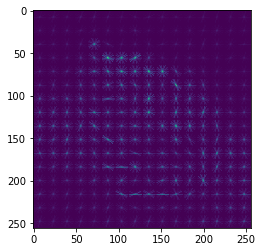

In [15]:
grey_img = rgb2grey(img)
hog_features, hog_image = hog(grey_img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
plt.imshow(hog_image)

In [16]:
def create_feature_matrix(imgs_df):
    features_list = []
    for img_row in range(len(imgs_df)):
        img = get_image(imgs_df.iloc[img_row])
        grey_img = rgb2grey(img)
        hog_features = hog(grey_img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
        features_list.append(hog_features)
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(df_svm)

<ipython-input-16-1bf34b6db5f3>:5: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  grey_img = rgb2grey(img)


In [17]:
feature_matrix.shape

(6000, 15876)

In [18]:
X = pd.DataFrame(feature_matrix)
y = pd.Series(df_svm['Binary'].values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.4,
                                                    random_state=42)

In [19]:
print(pd.Series(y_train).value_counts())

1    1832
0    1768
dtype: int64


In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print('Number of components after fitting the pca model=', pca.n_components_)

Number of components after fitting the pca model= 1364


In [22]:
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
print("Calculating SVM model accuracy")
scores = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {scores*100}")

Calculating SVM model accuracy
Test Accuracy: 77.16666666666666
